# Ookla Internet - Fixed Internet Analysis

## Annual Trends (Download and Upload Speeds)

### Download Trends

In [1]:

import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool

output_notebook(hide_banner=True)

df = pd.read_csv("./processed_data/algeria_national_trends_fixed.csv").copy()
df['year'] = df['date'].str.slice(0, 4).astype(int)
yearly = (df.groupby('year', as_index=False)['avg_download_mbps']
            .mean().rename(columns={'avg_download_mbps':'download_mbps'}))
yearly = yearly.sort_values('year')

src = ColumnDataSource(yearly)

p = figure(title="Algeria – Yearly Download Speed (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

p.line('year', 'download_mbps', source=src, line_width=3)
p.scatter('year', 'download_mbps', source=src, size=8)

p.add_tools(HoverTool(tooltips=[("Year", "@year"), ("Download (Mbps)", "@download_mbps{0.00}")],
                      mode='vline'))
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Download (Mbps)"

show(p)



## Upload Trends

In [2]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool

output_notebook(hide_banner=True)

df = pd.read_csv("processed_data/algeria_national_trends_fixed.csv").copy()
df['year'] = df['date'].str.slice(0, 4).astype(int)
yearly = (df.groupby('year', as_index=False)['avg_upload_mbps']
            .mean().rename(columns={'avg_upload_mbps':'upload_mbps'}))
yearly = yearly.sort_values('year')

src = ColumnDataSource(yearly)

p = figure(title="Algeria – Yearly Upload Speed (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

p.line('year', 'upload_mbps', source=src, line_width=3)
p.scatter('year', 'upload_mbps', source=src, size=8)

p.add_tools(HoverTool(tooltips=[("Year", "@year"), ("Upload (Mbps)", "@upload_mbps{0.00}")],
                      mode='vline'))
p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Upload (Mbps)"

show(p)


# Trends -  ADMN1

## Download -  ADMN1

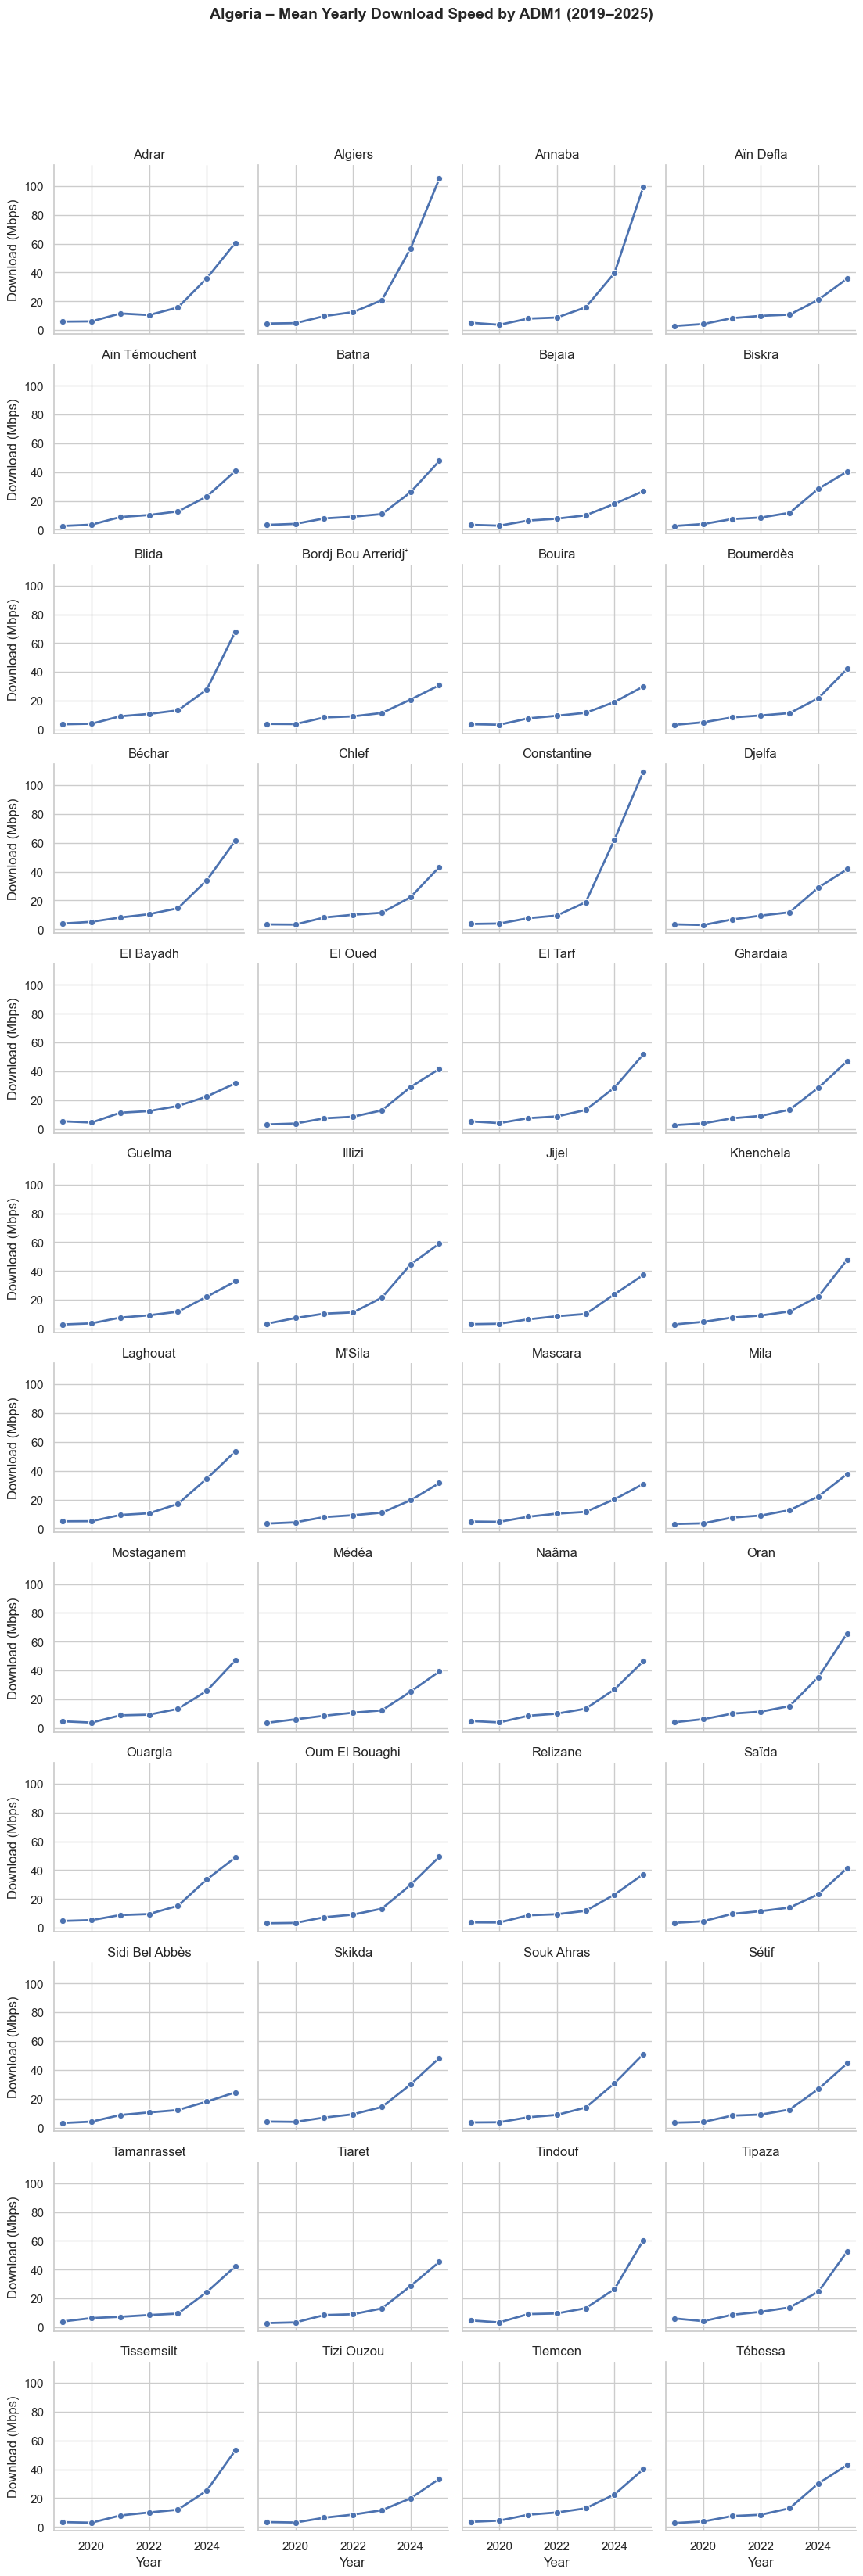

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load subnational data
df = pd.read_csv("processed_data/algeria_subnational_trends_fixed.csv")

# Keep ADM1 only and build yearly means
adm1 = df[df["admin_level"] == "ADM1"].copy()
adm1["year"] = adm1["date"].str.slice(0, 4).astype(int)
yearly = (adm1.groupby(["admin_name", "year"], as_index=False)["avg_download_mbps"]
               .mean()
               .rename(columns={"avg_download_mbps": "download_mbps"}))

# Faceted line charts
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly.sort_values("admin_name"),
                  col="admin_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="download_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Download (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Mean Yearly Download Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")
plt.show()


## Upload -  ADMN1

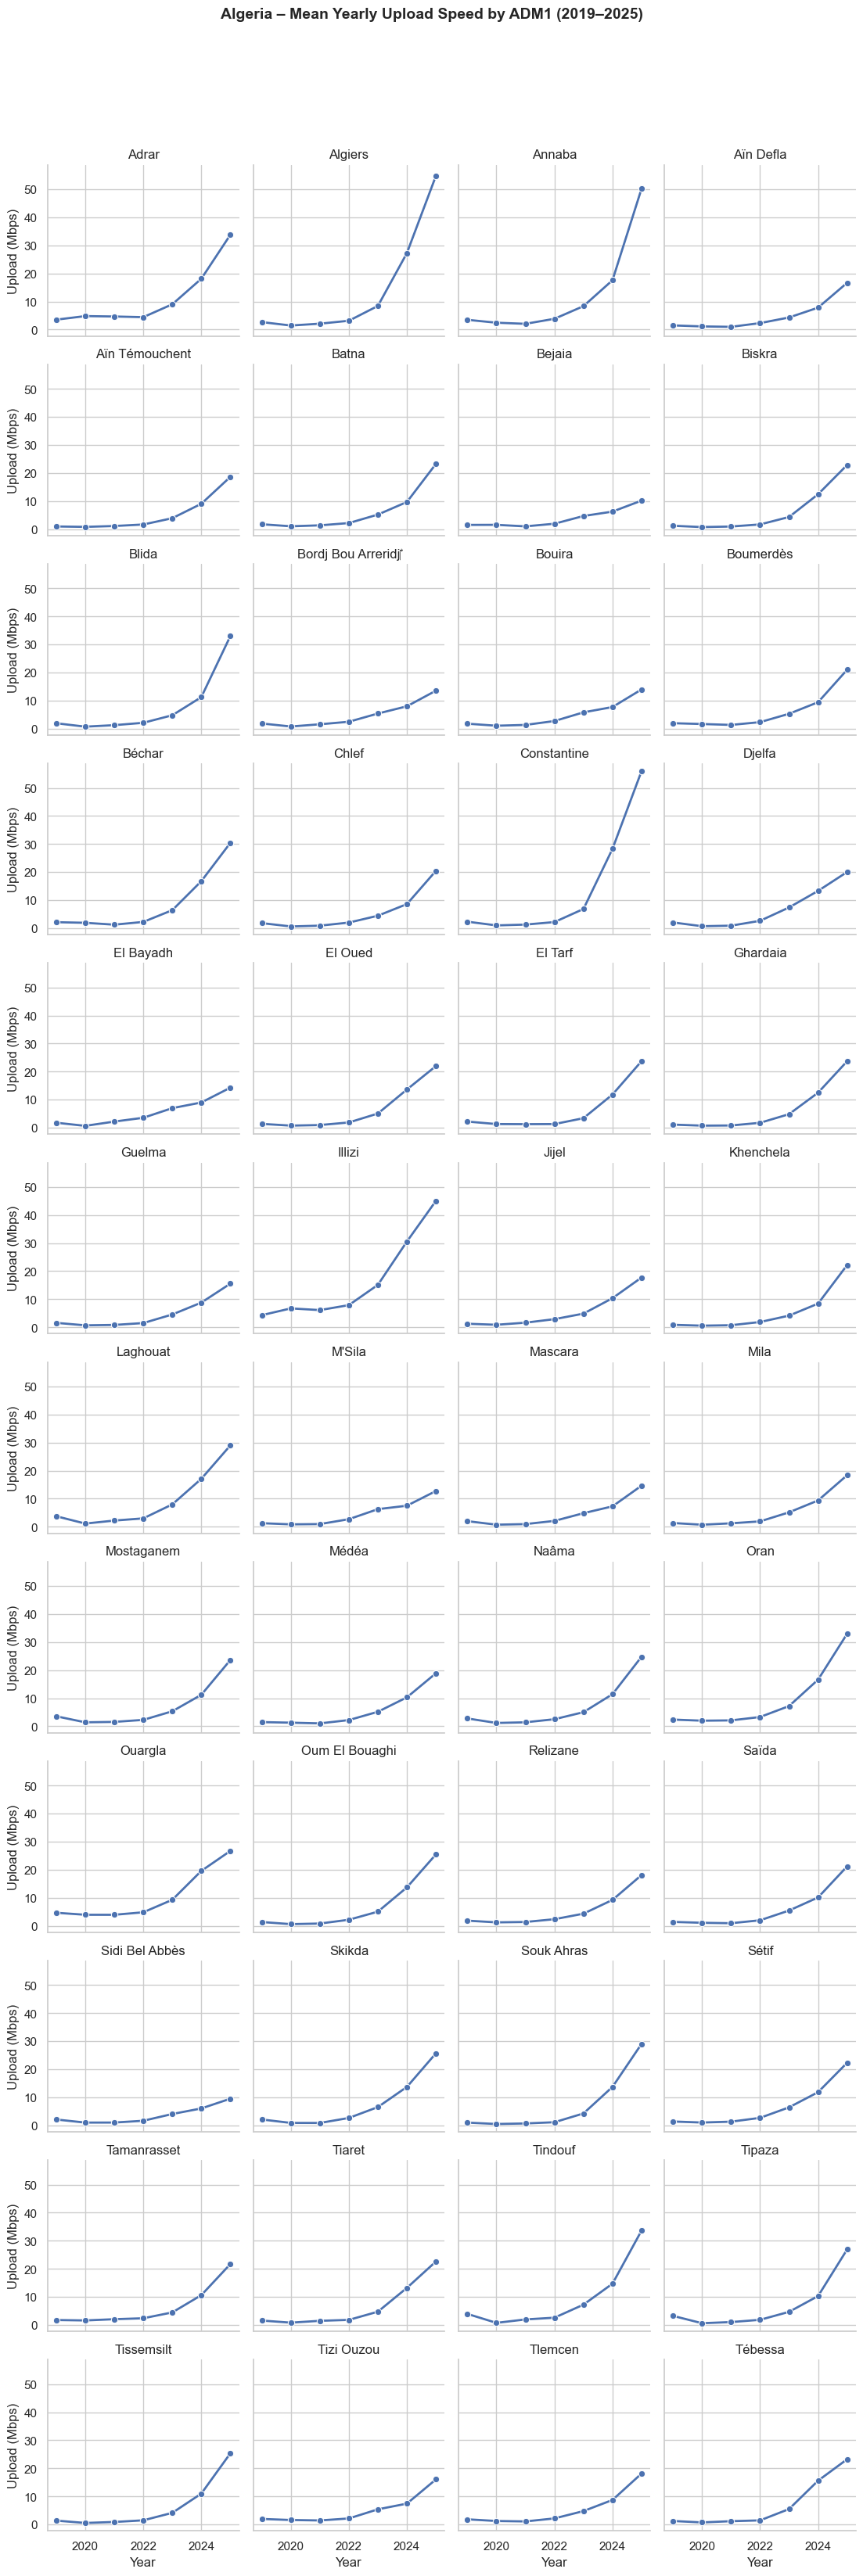

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load subnational data
df = pd.read_csv("processed_data/algeria_subnational_trends_fixed.csv")

# Keep ADM1 only and build yearly means
adm1 = df[df["admin_level"] == "ADM1"].copy()
adm1["year"] = adm1["date"].str.slice(0, 4).astype(int)
yearly = (adm1.groupby(["admin_name", "year"], as_index=False)["avg_upload_mbps"]
               .mean()
               .rename(columns={"avg_upload_mbps": "upload_mbps"}))

# Faceted line charts
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly.sort_values("admin_name"),
                  col="admin_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="upload_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Upload (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Mean Yearly Upload Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")
plt.show()


# Trends -  ADMN3

The figures below show maps at admin level 3 between 2019 and 2025. You can filter to view trends in download, upload and latency.

In [5]:
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Select, CustomJS
from bokeh.plotting import figure
from bokeh.layouts import column

output_notebook(hide_banner=True)

# Read with a Unicode-friendly codec
df = pd.read_csv("processed_data/algeria_subnational_trends_fixed.csv", encoding="utf-8-sig")

# Filter ADM3 and build year correctly
adm3 = df[df["admin_level"] == "ADM3"].copy()
adm3["year"] = adm3["date"].astype(str).str.slice(0, 4).astype(int)

# Clean and filter commune names
adm3["admin_name"] = adm3["admin_name"].astype(str).str.strip()
valid_names = (
    adm3["admin_name"].notna()
    & (adm3["admin_name"] != "")
    & ~adm3["admin_name"].str.contains(r"\?")
    & adm3["admin_name"].str.match(r"^[A-Za-zÀ-ÿ'\-\s]+$")
)
adm3 = adm3[valid_names]

# Yearly mean per commune
yearly = (
    adm3.groupby(["admin_name", "year"], as_index=False)
        .agg(
            download=("avg_download_mbps", "mean"),
            upload=("avg_upload_mbps", "mean")
        )
)

# Build clean option list
wilayas = sorted(yearly["admin_name"].unique().tolist())
default_w = wilayas[0]

# JS-serialisable map: commune -> arrays
data_map = {
    w: {
        "year": yearly.loc[yearly.admin_name.eq(w), "year"].tolist(),
        "download": yearly.loc[yearly.admin_name.eq(w), "download"].tolist(),
        "upload": yearly.loc[yearly.admin_name.eq(w), "upload"].tolist(),
    }
    for w in wilayas
}

src = ColumnDataSource(data=data_map[default_w])

p = figure(
    height=420,
    width=820,
    title=f"Yearly Speed – {default_w}",
    x_axis_label="Year",
    y_axis_label="Mbps",
    tools="pan,wheel_zoom,box_zoom,reset,save,hover",
    toolbar_location="right"
)

p.line("year", "download", source=src, line_width=3, legend_label="Download", line_color="steelblue")
p.scatter("year", "download", source=src, size=7, color="steelblue")
p.line("year", "upload",   source=src, line_width=3, legend_label="Upload",   line_color="orange")
p.scatter("year", "upload", source=src, size=7, color="orange")

p.legend.click_policy = "hide"
p.select_one(HoverTool).tooltips = [
    ("Year", "@year"),
    ("Download", "@download{0.00}"),
    ("Upload", "@upload{0.00}")
]

selector = Select(title="Commune (ADM3):", value=default_w, options=wilayas)

selector.js_on_change(
    "value",
    CustomJS(args=dict(src=src, dataMap=data_map, fig=p), code="""
        const w = cb_obj.value;
        const d = dataMap[w];
        src.data = {year: d.year, download: d.download, upload: d.upload};
        src.change.emit();
        fig.title.text = `Yearly Speed – ${w}`;
    """)
)

show(column(selector, p))


/Users/toweramoyo/anaconda3/envs/algeria_economic_monitoring/lib/python3.11/site-packages/shapely/constructive.py:1177: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)


# Population-Weighted Internet Speed Trends


### Comparison - Download Data

In [6]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend

output_notebook(hide_banner=True)

df1 = pd.read_csv("./processed_data/algeria_national_trends_fixed.csv").copy()

df1['year'] = df1['date'].str.slice(0, 4).astype(int)
yearly = (df1.groupby('year', as_index=False)['avg_download_mbps']
          .mean().rename(columns={'avg_download_mbps': 'download_mbps'}))
yearly = yearly.sort_values('year')
src1 = ColumnDataSource(yearly)

df2 = pd.read_csv("processed_data/algeria_pop_weighted_trends_2019_2025_fixed.csv").copy()
df2 = df2.sort_values("year")
src2 = ColumnDataSource(df2)

p = figure(title="Algeria – Download Speed Trends (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

line1 = p.line('year', 'download_mbps', source=src1, line_width=3, legend_label="National Avg")
p.scatter('year', 'download_mbps', source=src1, size=8)

line2 = p.line('year', 'pw_download_mbps', source=src2, line_width=3, color='orange', legend_label="Population-weighted Avg")
p.scatter('year', 'pw_download_mbps', source=src2, size=8, color='orange')

p.add_tools(HoverTool(tooltips=[
    ("Year", "@year"),
    ("Download (Mbps)", "$y{0.00}")
], mode='vline'))

p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Download (Mbps)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


In [7]:
import pandas as pd
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, Legend

output_notebook(hide_banner=True)

df1 = pd.read_csv("./processed_data/algeria_national_trends_fixed.csv").copy()
df1['year'] = df1['date'].str.slice(0, 4).astype(int)
yearly = (df1.groupby('year', as_index=False)['avg_upload_mbps']
          .mean().rename(columns={'avg_upload_mbps': 'upload_mbps'}))
yearly = yearly.sort_values('year')
src1 = ColumnDataSource(yearly)

df2 = pd.read_csv("processed_data/algeria_pop_weighted_trends_2019_2025_fixed.csv").copy()
df2 = df2.sort_values("year")
src2 = ColumnDataSource(df2)

p = figure(title="Algeria – Upload Speed Trends (Mbps)",
           x_axis_type="linear", height=400, width=800,
           tools="pan,wheel_zoom,box_zoom,reset,save")

line1 = p.line('year', 'upload_mbps', source=src1, line_width=3, legend_label="National Avg")
p.scatter('year', 'upload_mbps', source=src1, size=8)

line2 = p.line('year', 'pw_upload_mbps', source=src2, line_width=3, color='orange', legend_label="Population-weighted Avg")
p.scatter('year', 'pw_upload_mbps', source=src2, size=8, color='orange')

p.add_tools(HoverTool(tooltips=[
    ("Year", "@year"),
    ("Download (Mbps)", "$y{0.00}")
], mode='vline'))

p.xaxis.axis_label = "Year"
p.yaxis.axis_label = "Upload (Mbps)"
p.legend.location = "top_left"
p.legend.click_policy = "hide"

show(p)


## Population-Weighted Average Download Analysis (ADMN 1)

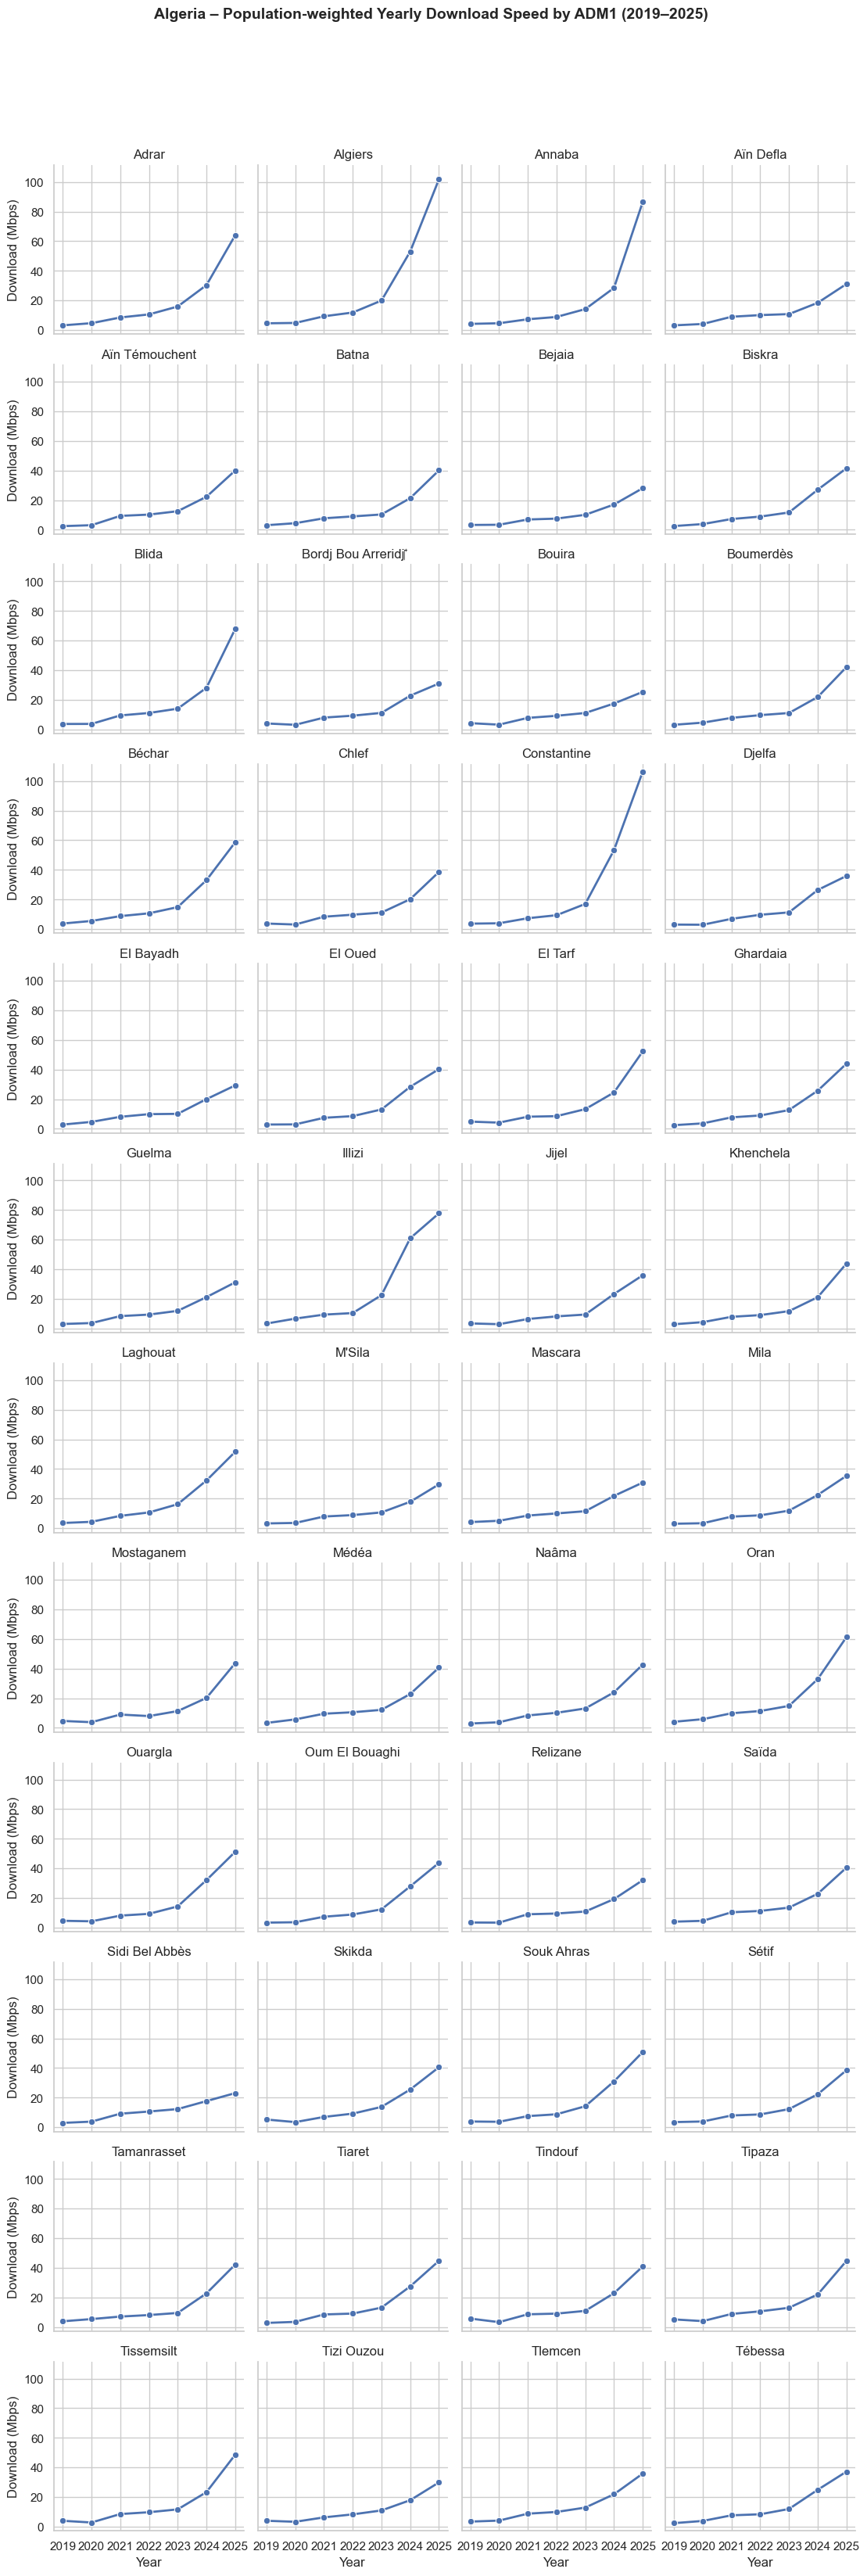

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_data/algeria_pop_weighted_adm1_2019_2025_fixed.csv")

df["year"] = df["year"].astype(int)
yearly = (df[["adm1_name", "year", "pw_download_mbps"]]
            .rename(columns={"pw_download_mbps": "download_mbps"})
            .sort_values(["adm1_name", "year"]))

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly, col="adm1_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="download_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Download (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Population-weighted Yearly Download Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")

for ax in g.axes.flatten():
    ax.set_xticks(sorted(yearly["year"].unique()))

plt.show()


## Population-Weighted Average Upload Analysis (ADMN 1)

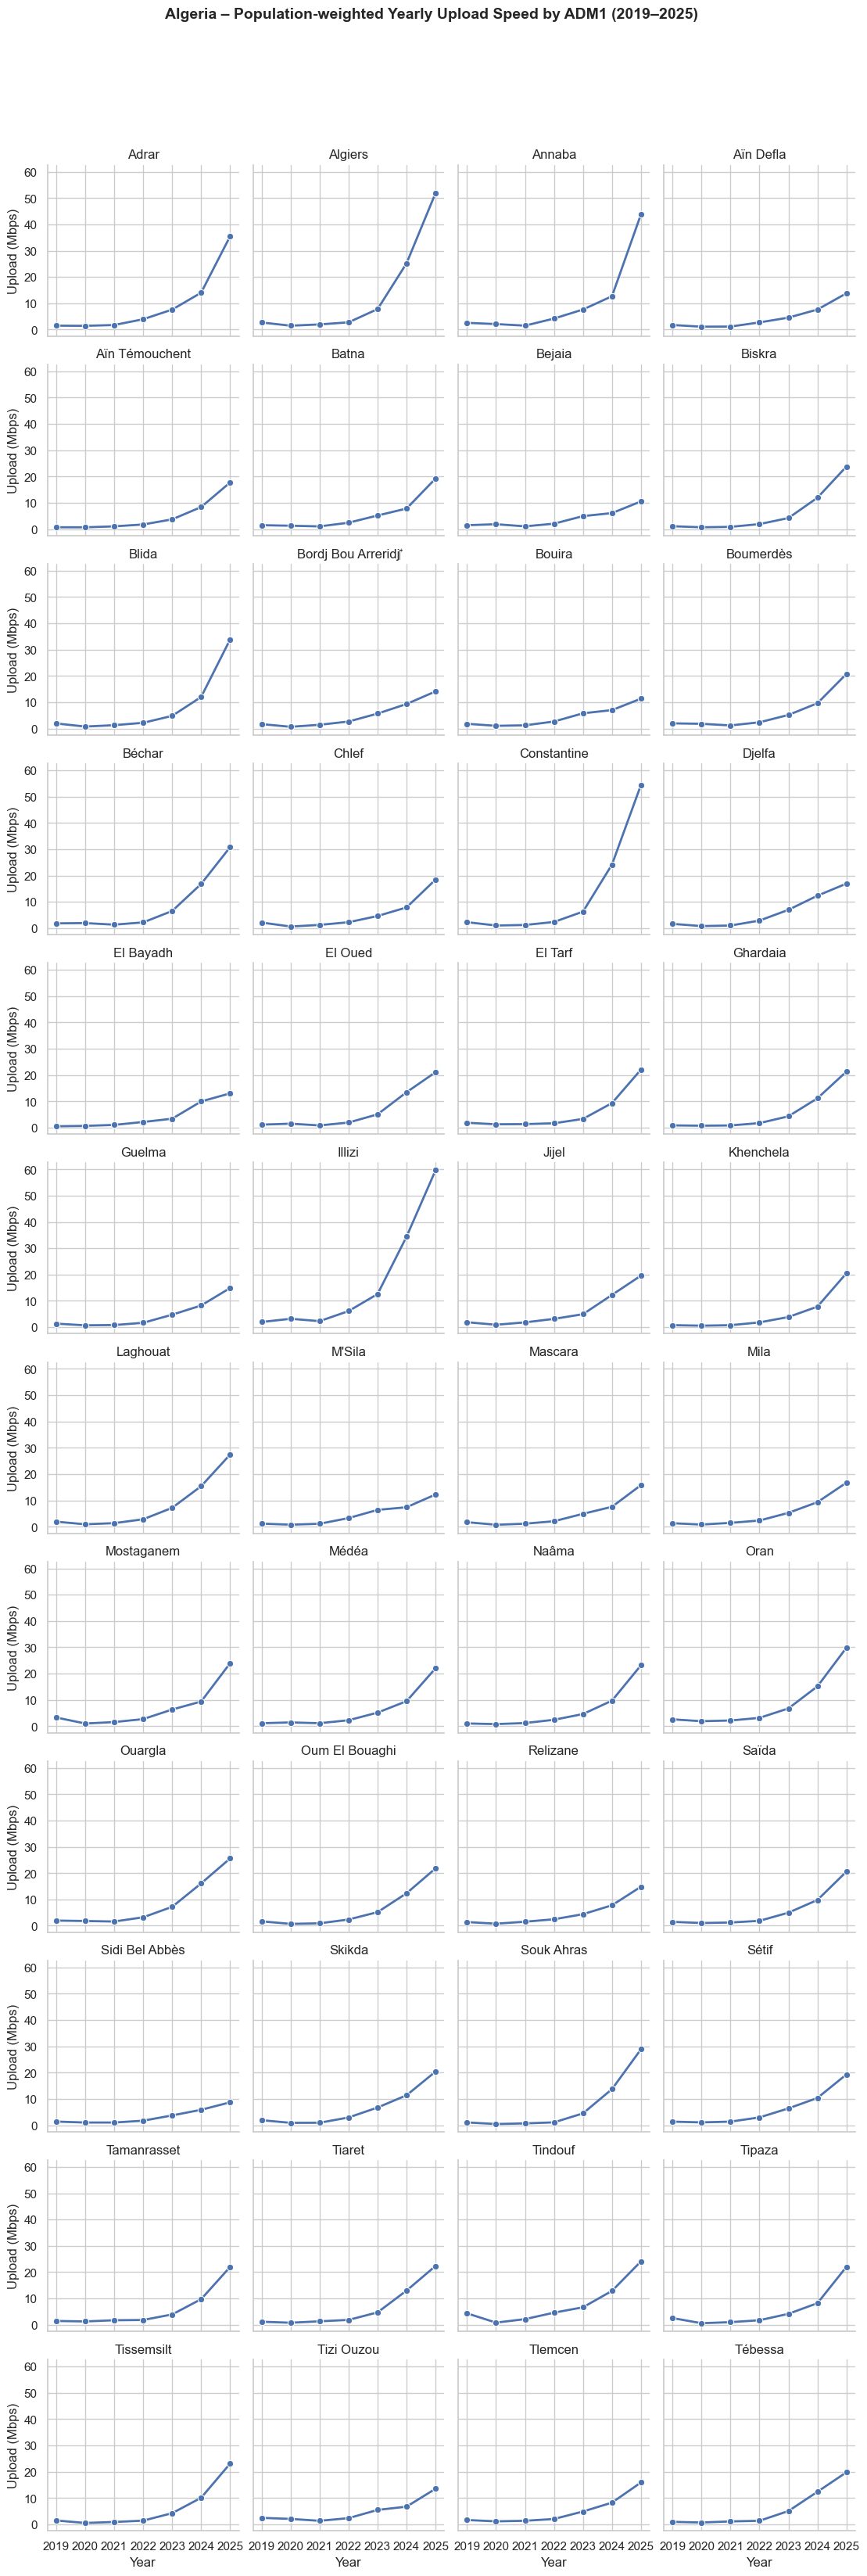

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("processed_data/algeria_pop_weighted_adm1_2019_2025_fixed.csv")

df["year"] = df["year"].astype(int)
yearly = (df[["adm1_name", "year", "pw_upload_mbps"]]
            .rename(columns={"pw_upload_mbps": "upload_mbps"})
            .sort_values(["adm1_name", "year"]))

sns.set_theme(style="whitegrid")
g = sns.FacetGrid(yearly, col="adm1_name", col_wrap=4, height=2.8, sharey=True)
g.map_dataframe(sns.lineplot, x="year", y="upload_mbps", marker="o", linewidth=2)
g.set_axis_labels("Year", "Upload (Mbps)")
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.92)
g.fig.suptitle("Algeria – Population-weighted Yearly Upload Speed by ADM1 (2019–2025)", fontsize=14, weight="bold")

for ax in g.axes.flatten():
    ax.set_xticks(sorted(yearly["year"].unique()))

plt.show()
